In [ ]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

In [ ]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------
# The Reuters Corpus is a collection of news documents,
# often used for tasks such as document classification or clustering

[nltk_data] Downloading package reuters to /root/nltk_data...


In [ ]:
from collections import defaultdict

In [ ]:
print(reuters.fileids('crude'))

['test/14829', 'test/15063', 'test/15200', 'test/15230', 'test/15238', 'test/15244', 'test/15322', 'test/15339', 'test/15344', 'test/15351', 'test/15520', 'test/15939', 'test/15964', 'test/16005', 'test/16007', 'test/16040', 'test/16077', 'test/16366', 'test/16429', 'test/16438', 'test/16593', 'test/16607', 'test/16636', 'test/16649', 'test/16651', 'test/16658', 'test/16710', 'test/16723', 'test/16739', 'test/16762', 'test/17054', 'test/17478', 'test/17516', 'test/17519', 'test/17584', 'test/17618', 'test/17658', 'test/17669', 'test/17750', 'test/17757', 'test/17771', 'test/17780', 'test/17813', 'test/17816', 'test/17875', 'test/17886', 'test/17888', 'test/17892', 'test/17913', 'test/17929', 'test/17963', 'test/18066', 'test/18085', 'test/18108', 'test/18146', 'test/18186', 'test/18213', 'test/18234', 'test/18311', 'test/18325', 'test/18329', 'test/18332', 'test/18340', 'test/18493', 'test/18521', 'test/18523', 'test/18621', 'test/18651', 'test/18655', 'test/18678', 'test/18680', 'test

In [ ]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [ ]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [ ]:
# reuters_corpus is a list of lists
def distinct_words(corpus):
  corpus_words=set()
  for files in corpus:
    for words in files:
      corpus_words.add(words)
  corpus_words=sorted(list(corpus_words))
  return corpus_words, len(corpus_words)

In [ ]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
  corpus_words=distinct_words(corpus)[0]
  num_corpus_words=distinct_words(corpus)[1]
  M=np.zeros((num_corpus_words,num_corpus_words))
  word2ind = defaultdict(int)
  # dict with (key,val)=(word,idx in M)
  for i in range(num_corpus_words):
    word2ind[corpus_words[i]]=i
  for files in corpus:
    for idx,c_words in enumerate(files):
      l_p, r_p = max(0,idx-window_size), min(idx+window_size,len(files)-1)
      j=l_p
      while j <= r_p :
        if j != idx:
          M[word2ind[c_words],word2ind[files[j]]]+=1
        j+=1
  return M, word2ind

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [ ]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M, k=2):
    n_iters = 10  # Number of iterations for SVD to converge
    # Initialize TruncatedSVD from Scikit-learn
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    # Fit the SVD model to the matrix and perform dimensionality reduction
    M_reduced = svd.fit_transform(M)
    print(f"Running Truncated SVD over {M.shape[0]} words...")
    print("Done.")
    return M_reduced

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [ ]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    plt.figure(figsize=(12,10))
    for word in words:
      if word in word2ind:
        x,y=M_reduced[word2ind[word]]
        plt.scatter(x,y,marker='x',color='blue')
        plt.text(x+0.001,y+0.001,word,fontsize=7)
    plt.title('word embedding')
    plt.xlabel('feature dim one')
    plt.ylabel('feature dim two')
    plt.grid(True)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


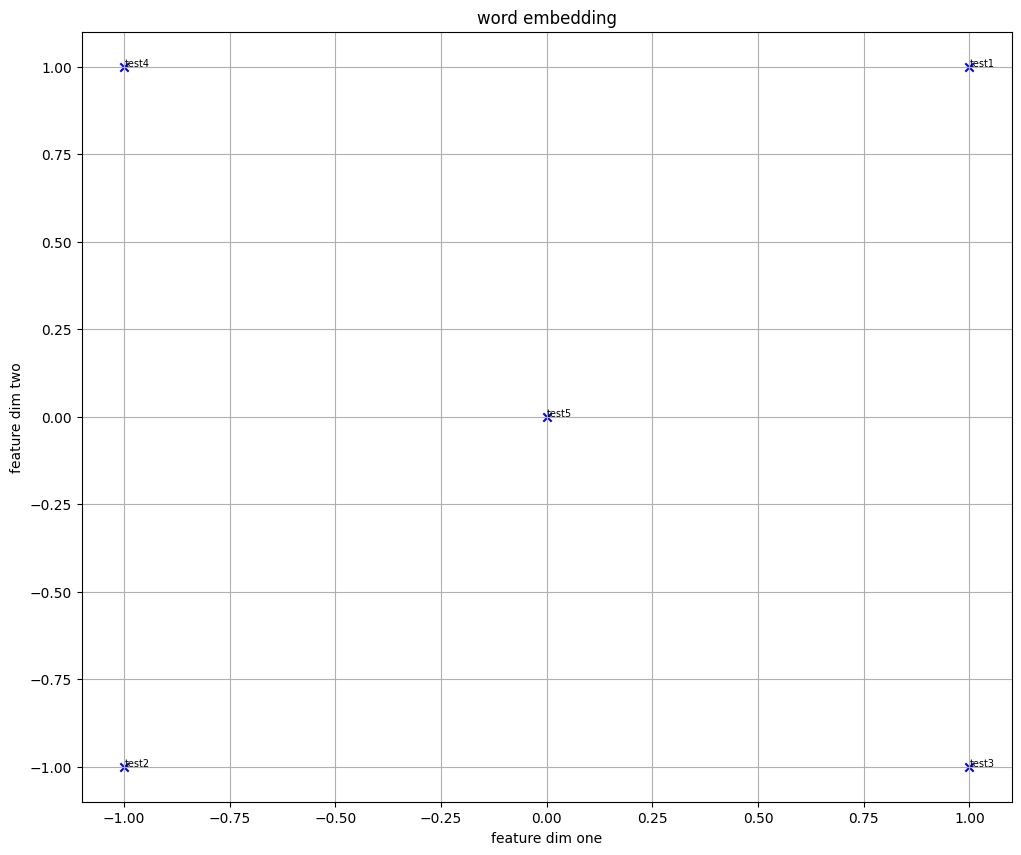

--------------------------------------------------------------------------------


In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------
print ("-" * 80)
print ("Outputted Plot:")
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)
print ("-" * 80)

Running Truncated SVD over 8185 words...
Done.


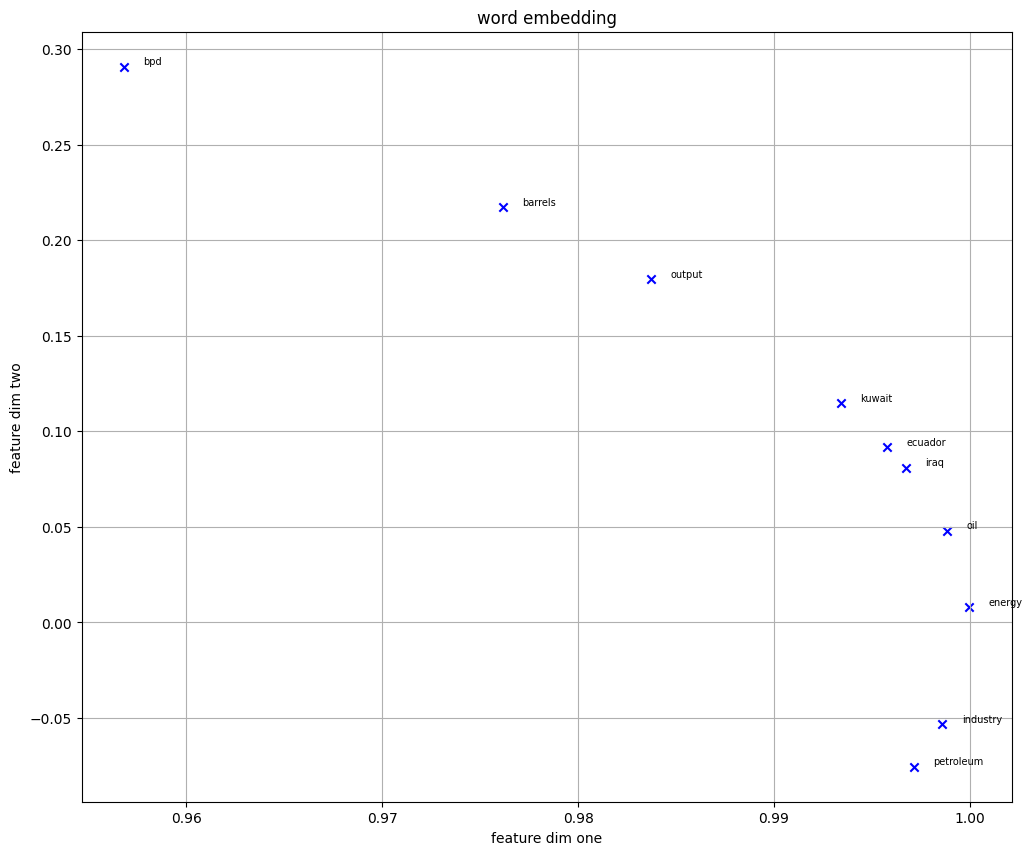

In [ ]:
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_normalized, word2ind_co_occurrence, words)

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All embeddings from GloVe (200-dimensional)
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.key_to_index))  # Use key_to_index instead of vocab
    return wv_from_bin

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [ ]:
wv_from_bin.key_to_index['queen']

2060

In [ ]:
kng=wv_from_bin['king']
qun=wv_from_bin['queen']
print(np.linalg.norm(kng-qun))

5.4948783


In [ ]:
egy=wv_from_bin['energy']
print(np.linalg.norm(kng-egy))

9.300834


In [ ]:
ol=wv_from_bin['oil']
print(np.linalg.norm(ol-egy))

7.105465


# ***SVD and Dimensionality reduction***

$$\alpha_{N}\big(\underbrace{X}_{[x_1,\ldots,x_N]},n,p\big):=\min_{dim(\mathcal{W})=p<n} \frac{1}{N} \sum_{i=1}^{N}\|x_{i}-P_{\mathcal{W}}(x_{i})\|^{2}. \hspace{15pt} \textit{(prob_1)}$$
essentially looking for $p-$ basis vector in $\mathbb{R}^{n}, [w_{1},w_{2},\ldots, w_{p}]:=W \in \mathbb{R}^{n \times p}$ and coefficients $c_{x_{i}}^{w} \in \mathbb{R}^{p}$ such that $\alpha_{N}(X,n,p)=\frac{1}{N} \sum_{i=1}^{N}\|x_{i}-Wc_{x_{i}}^{w}\|^{2}$. Now if $p < < n $, saves a lot of computational cost as original data can be expressed in lower dimesional features.

*By considering the eigenvalues of $XX^{*}$(which are squared version of singular values), moreover let $w_{0}:=\frac{1}{N}\sum_{i=1}^{N}x_{i}$ and consider the mean correct $X_{-}:=[x_{1}-w_{0},\ldots,x_{n}-w_{0}]$*, then solution to *Prob_1* can be computed using SVD, $X_{-}=U \Sigma V^{*}$. In particular, we can choose $W=U_{p}:= [u_1
,\ldots, u_p]$ to be the first $p$ columns of $U$ so that $P_{\mathcal{W}}(x)$ is essentially best approximation of the data point $x$ in span of $U_{p}$, mathematically said $P_{\mathcal{W}}(x)=U_{p}(\underbrace{U_{p}^{^{*}}U_{p}}_{I})^{-1}U_{p}^{^{*}}x$, which becuase of orthogonality of basis vectors in $U,V$ simplifies to:
$$P_{\mathcal{W}}(x)=U_{p}U_{p}^{^{*}}x$$

***When used for dimension reduction, the idea is to store $y_{i} \mapsto U_{p}^{^{*}}x_{i}$***


# ***Probabilistic-PCA***

***Random Projections***

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin[w])
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin[w])
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
import numpy as np
D=np.array([[4,1,-2],[-3,4,-1],[-4,0,1],[2,-2,3]])

In [ ]:
# Step 1: Center the data by subtracting the row mean (mean of each feature across samples)
D_mean = np.mean(D, axis=1, keepdims=True)  # Compute mean across columns (samples)
D_centered = D - D_mean  # Subtract row mean from each feature
p = 2
U,S,V_T=np.linalg.svd(D_centered)

In [ ]:
U_2=U[:,:2]
U_2.T @ D

array([[-6.19513031,  3.26618301, -0.68319913],
       [-2.3211392 , -3.01651708,  3.64699406]])

In [ ]:
import numpy as np
# Define the matrix D
D = np.array([[4, 1, -2],
              [-3, 4, -1],
              [-4, 0, 1],
              [2, -2, 3]])
# Define function to compute post-PCA data for a given p
def pca_reduction_coeff(D,p):
    # Step 1: Center the data by subtracting the row mean
    D_mean = np.mean(D, axis=1, keepdims=True)  # Compute mean across samples (columns)
    D_centered = D - D_mean  # Subtract row mean from each feature (row)
    # Step 2: Apply SVD
    U, S, VT = np.linalg.svd(D_centered, full_matrices=False)
    # Reduce to p dimensions
    U_reduced = U[:, :p]
    VT_reduced = VT[:p, :]
    # Step 3: Reconstruct the data in reduced dimension
    D_reduced = U_reduced.T @ D
    # Step 4: Add the mean back to the data
    # D_reconstructed = D_reduced + D_mean
    # Round the result to 2 decimal places
    return np.round(D_reduced,2)
# Step 5: Print the results for p = 0, 1, 2
for p in range(3):
    D_pca = pca_reduction_coeff(D, p)
    print(f"Post-PCA data matrix for p = {p}:\n", D_pca, "\n")

Post-PCA data matrix for p = 0:
 [] 

Post-PCA data matrix for p = 1:
 [[-6.2   3.27 -0.68]] 

Post-PCA data matrix for p = 2:
 [[-6.2   3.27 -0.68]
 [-2.32 -3.02  3.65]] 



In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
# Load MNIST dataset without any transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5468500.95it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 158732.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1507824.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2481183.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# best 30 dim subspace approximation of a 784 dimensional data point
def pca_reduction(D,p,add_mean):
    # Step 1: Center the data by subtracting the row mean
    if add_mean:
      D_mean = np.mean(D, axis=1, keepdims=True)  # Compute mean across samples (columns)
    else:
      D_mean = np.zeros(D.shape)
    D_centered = D - D_mean  # Subtract row mean from each feature (row)
    # Step 2: Apply SVD
    U, S, VT = np.linalg.svd(D_centered, full_matrices=False)
    # Reduce to p dimensions
    U_reduced = U[:, :p]
    # Step 3: Reconstruct the data in reduced dimension
    D_sub_reduced = U_reduced @ U_reduced.T @ D
    # Step 4: Add the mean back to the data
    # D_reconstructed = D_reduced + D_mean
    # Round the result to 2 decimal places
    #if add_mean:
    #  return np.round(D_sub_reduced,2)+D_mean
    # else:
    return np.round(D_sub_reduced,2)
add_mean = False
for p in range(5):
    if p == 4:
        print('Original data matrix:\n', D)
    else:
        D_pca_sub = pca_reduction(D, p, add_mean)
        D_pca_with_mean = pca_reduction(D, p, add_mean=True)
        print(f"Post-PCA data matrix for p = {p}:\n", D_pca_sub, "\nWith Mean:\n", D_pca_with_mean, "\n")

Post-PCA data matrix for p = 0:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 
With Mean:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 

Post-PCA data matrix for p = 1:
 [[ 2.87 -1.26  0.19]
 [-4.03  1.77 -0.26]
 [-3.29  1.44 -0.21]
 [ 2.57 -1.13  0.17]] 
With Mean:
 [[ 2.27 -1.2   0.25]
 [-4.44  2.34 -0.49]
 [-2.81  1.48 -0.31]
 [ 2.38 -1.26  0.26]] 

Post-PCA data matrix for p = 2:
 [[ 3.96  0.9  -2.11]
 [-3.28  3.25 -1.84]
 [-3.94  0.15  1.17]
 [ 1.68 -2.87  2.03]] 
With Mean:
 [[ 3.82  0.82 -2.18]
 [-3.68  3.32 -1.68]
 [-3.78  0.22  1.22]
 [ 1.17 -2.83  2.17]] 

Post-PCA data matrix for p = 3:
 [[ 4.  1. -2.]
 [-3.  4. -1.]
 [-4. -0.  1.]
 [ 2. -2.  3.]] 
With Mean:
 [[ 3.75  0.75 -2.25]
 [-3.05  3.95 -1.05]
 [-4.25 -0.25  0.75]
 [ 1.85 -2.15  2.85]] 

Original data matrix:
 [[ 4  1 -2]
 [-3  4 -1]
 [-4  0  1]
 [ 2 -2  3]]


In [ ]:
obsv_image=[]
for image,label in trainset:
  # image is PIL.Image.Image object.
  if label == 2:
    obsv_image.append(np.array(image).reshape(-1))
# we want columns to represent a sample so:
obsv_image=np.array(obsv_image).T
# obsv_image.shape = (784, 5958)

In [ ]:
red_sub_dim_flattened_image = pca_reduction(obsv_image,30,add_mean=True)

In [ ]:
from PIL import Image
def recon_low_sub(red_sub_dim_flattened_image, col_idx,new_size=(56, 56)):
    # Unflatten the specified column into a 28x28 array
    unflattened_image = red_sub_dim_flattened_image[:, col_idx].reshape(28, 28)
    # Scale the pixel values to the range [0, 255] for display
    scaled_image = (unflattened_image - unflattened_image.min()) / (unflattened_image.max() - unflattened_image.min()) * 255
    scaled_image = scaled_image.astype(np.uint8)
    # Converts the floating-point values in scaled_image(floats) to 8-bit unsigned integers (uint8),
    # which is the required data type for most image processing libraries , including PIL.
    # Create and return a PIL image
    # Create a PIL image
    pil_image = Image.fromarray(scaled_image)
    # Resize the image to the specified size
    pil_image_resized = pil_image.resize(new_size, Image.LANCZOS)
    return pil_image_resized

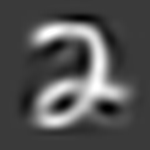

In [ ]:
recon_low_sub(red_sub_dim_flattened_image,177,new_size=(150, 150))

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualizing some samples
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plot some images
fig, axes = plt.subplots(1, 6, figsize=(10, 4))
for i in range(6):
    axes[i].imshow(images[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')
plt.show()


784


In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


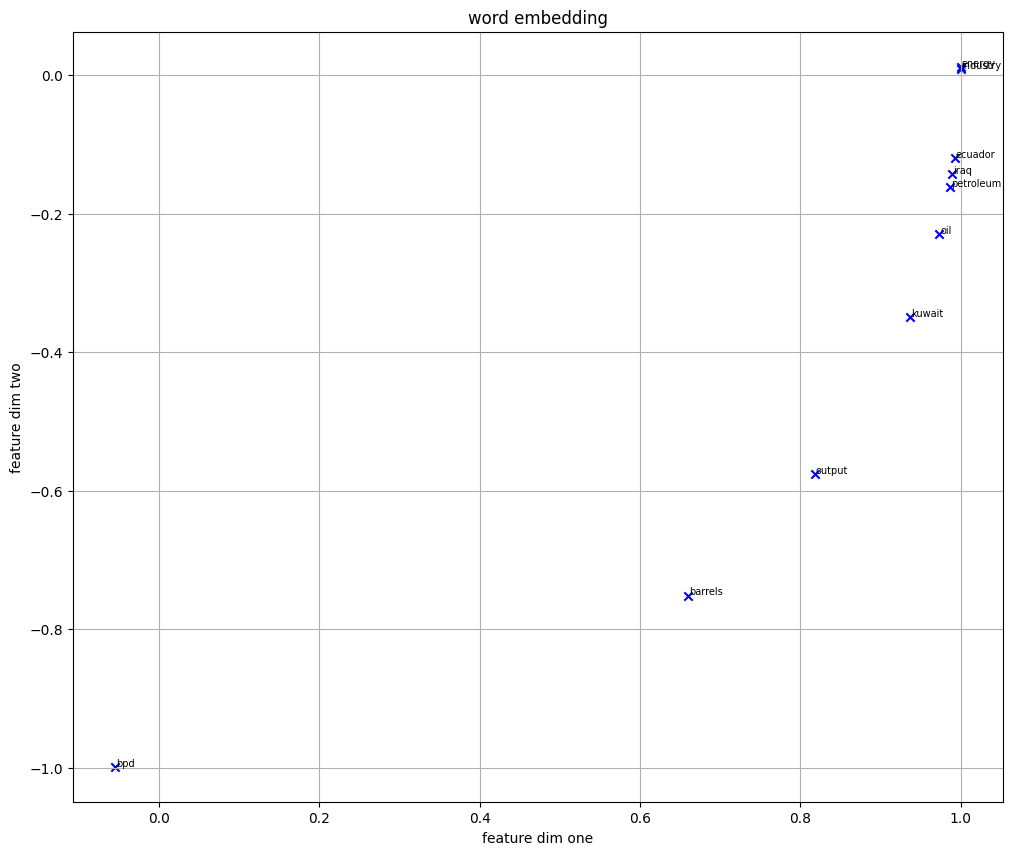

In [ ]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)